In [5]:
# !pip install numpy matplotlib seaborn scipy astropy statsmodels emcee corner tqdm ellc dynesty celerite h5py rebound
import numpy as np
import os, sys
import pandas as pd
import h5py 
import emcee


current_path = '/Volumes/SSDDISK/MacMiniM2/MyOwnCode/K2_140_plot/'
os.chdir(os.path.join(current_path, 'results'))
sys.path.append('/Users/wangxianyu/Program/allesfitter-master')  ### add allesfitter path
import allesfitter
datadir = current_path 

In [6]:
from matplotlib.ticker import MultipleLocator, \
    FormatStrFormatter, AutoMinorLocator
def ticksetax(ax, labelsize=15, ticksize=12, tickwidth=1.5, ticklength=5):
    ax.tick_params(direction='in', which='both',  width=2,colors='k', bottom='True',top='True', left='True', right='True', labelsize=15)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
def get_params(key,samples):
    ind = np.where(config.BASEMENT.fitkeys==key)[0]
    if len(ind)==1: 
        return samples[:,ind].flatten() #if it was fitted for
    else: 
        try:
            if config.BASEMENT.params[key] is None:
                return np.nan #if None, retun nan instead
            else:
                return config.BASEMENT.params[key] #else take the input value
        except KeyError:
            return np.nan #if all fails, return nan
        
import pandas as pd
def bin_lightcurve_fast(times, fluxes, flux_errs, time_bin_size):
    df = pd.DataFrame({'time': times, 'flux': fluxes, 'flux_err': flux_errs})

    # Define root-mean-square function for flux_err
    def rmse(x):
        return np.sqrt(np.sum(np.square(x))) / len(x)

    bin_labels = (df['time'] / time_bin_size).astype(int)
    binned_df = df.groupby(bin_labels).agg({
        'time': 'mean',
        'flux': 'mean',
        'flux_err': rmse  
    })
    return binned_df['time'].values, binned_df['flux'].values, binned_df['flux_err'].values


### Load setting, parameter files and posteriors

In [7]:
from allesfitter import config
from allesfitter.mcmc import mcmc_lnprob
from allesfitter.mcmc_output import draw_mcmc_posterior_samples
config.init(datadir,quiet=True)
# allesfitter.mcmc_fit(datadir)

In [9]:

params = config.BASEMENT.params
settings = config.BASEMENT.settings
companions_phot = config.BASEMENT.settings['companions_phot']
lnlike_total = 0
if config.BASEMENT.settings['transittiming'] is not None:
    transittiming_list = config.BASEMENT.settings['transittiming']
    letters = ['b','c','d','e','f','g','h','i','j','k','l','m','n','o','p']
    for i,transittiming in enumerate(transittiming_list.split(',')):
        # print(i)
        this_letter = letters[i]
        print(i,this_letter)
    
        transittiming = [float(x) for x in transittiming.split(' ')]
        # odd 
        tt = transittiming[0::2]
        # even
        tt_err = transittiming[1::2]

        period = params[this_letter+'_period']
        tc = params[this_letter+'_epoch']
        epochs = np.round((np.array(tt) - tc)/period,0) * period + tc
        pred_tt = epochs * period + tc
        residuals = np.array(tt) - pred_tt
        inv_sigma2_w = 1./(np.array(tt_err)**2)
        lnlike_total += -0.5*(np.sum((residuals)**2 * inv_sigma2_w - np.log(inv_sigma2_w/2./np.pi))) 
        

0 b


### Make a copy of the posterior samples to avoid overwriting and polluting the original ones

In [11]:
from shutil import copyfile
copyfile(os.path.join(config.BASEMENT.outdir,'mcmc_save.h5'), os.path.join(config.BASEMENT.outdir,'mcmc_save_tmp.h5'))

'/Volumes/SSDDISK/MacMiniM2/MyOwnCode/K2_140_plot/results/mcmc_save_tmp.h5'

### Import all posterior samples into the memory for further processing

In [12]:
reader = emcee.backends.HDFBackend( os.path.join(config.BASEMENT.outdir,'mcmc_save_tmp.h5'), read_only=True )
completed_steps = reader.get_chain().shape[0]*config.BASEMENT.settings['mcmc_thin_by']
posterior_samples = draw_mcmc_posterior_samples(reader)#, Nsamples=200) # 

### Get Instruments

In [13]:
inst_rvs = config.BASEMENT.settings['inst_rv'].copy()
inst_rms = []

for key in config.BASEMENT.settings.keys():
    if ('flux_weighted' in key) and (config.BASEMENT.settings[key] is True):
        inst_rms.append('_'.join(key.split('_')[3:]))

for inst_rm in inst_rms:
    if inst_rm in inst_rvs:
        inst_rvs.remove(inst_rm)

inst_phots = config.BASEMENT.settings['inst_phot'].copy()
print('Photometric measurements: ', inst_phots)
print('Radial velocity measurements: ', inst_rvs)
print('Rossiter-McLaughlin measurements: ', inst_rms)

Photometric measurements:  ['140K2']
Radial velocity measurements:  ['140FEILS', 'CORALIE', 'HARPS']
Rossiter-McLaughlin measurements:  ['KeckK2-140']


In [14]:
from allesfitter.general_output import *
from allesfitter.computer import *


# calculate_baseline
###############################################################################
#::: plot_1 (helper function)
###############################################################################
def plot_my(ax, samples, inst, companion, style,
           base=None, dt=None, data_type=None,
           zoomwindow=None, force_binning=False,
           kwargs_data=None,
           kwargs_model=None,
           kwargs_ax=None):
    '''
    Inputs:
    -------
    ax : matplotlib axis

    samples : array
        Prior or posterior samples to plot the fit from

    inst: str
        Name of the instrument (e.g. 'TESS')

    companion : None or str
        None or 'b'/'c'/etc.

    style: str
        'full' / 'per_transit' / 'phase' / 'phasezoom' / 'phasezoom_occ' /'phase_curve'
        'full_residuals' / 'phase_residuals' / 'phasezoom_residuals' / 'phasezoom_occ_residuals' / 'phase_curve_residuals'

    zoomwindow: int or float
        the full width of the window to zoom into (in hours)
        default: 8 hours

    base: a BASEMENT class object
        (for internal use only)

    dt : float
        time steps on which the model should be evaluated for plots
        in days
        default for style='full': 2 min for <1 day of data; 30 min for >1 day of data.

    Notes:
    ------
    yerr / epoch / period:
        come either from
        a) the initial_guess value or
        b) the MCMC median,
        depending on what is plotted (i.e. not from individual samples)

    '''

    #==========================================================================
    #::: interpret input
    #==========================================================================
    if base==None:
        base = config.BASEMENT

    if samples is not None:
        params_median, params_ll, params_ul = get_params_from_samples(samples)

    if kwargs_data is None: kwargs_data = {}
    if 'label' not in kwargs_data: kwargs_data['label'] = inst
    if 'marker' not in kwargs_data: kwargs_data['marker'] = '.'
    if 'markersize' not in kwargs_data: kwargs_data['markersize'] = 8.
    if 'linestyle' not in kwargs_data: kwargs_data['linestyle'] = 'none'
    if 'color' not in kwargs_data: kwargs_data['color'] = 'b'
    if 'alpha' not in kwargs_data: kwargs_data['alpha'] = 1.
    if 'rasterized' not in kwargs_data: kwargs_data['rasterized'] = True

    if kwargs_model is None: kwargs_model = {}
    if 'marker' not in kwargs_model: kwargs_model['marker'] = 'none'
    if 'markersize' not in kwargs_model: kwargs_model['markersize'] = 0.
    if 'linestyle' not in kwargs_model: kwargs_model['linestyle'] = '-'
    if 'color' not in kwargs_model: kwargs_model['color'] = 'r'
    if 'alpha' not in kwargs_model: kwargs_model['alpha'] = 1.

    if kwargs_ax is None: kwargs_ax = {}
    if 'title' not in kwargs_ax: kwargs_ax['title'] = None
    if 'xlabel' not in kwargs_ax: kwargs_ax['xlabel'] = None
    if 'ylabel' not in kwargs_ax: kwargs_ax['ylabel'] = None

    timelabel = 'Time' #removed feature


    #==========================================================================
    #::: helper fct
    #==========================================================================
    def set_title(title1):
        if kwargs_ax['title'] is None: return title1
        else: return kwargs_ax['title']


    #==========================================================================
    #::: do stuff
    #==========================================================================
    if inst in base.settings['inst_phot']:
        key='flux'
        baseline_plus = 1.
        if style in ['full']:
            ylabel = 'Relative Flux'
        elif style in ['full_minus_offset']:
            ylabel = 'Relative Flux - Offset'
        elif style in ['phase', 'phasezoom', 'phasezoom_occ', 'phase_curve']:
            ylabel = 'Relative Flux - Baseline'
        elif style in ['full_residuals', 'phase_residuals', 'phasezoom_residuals', 'phasezoom_occ_residuals', 'phase_curve_residuals']:
            ylabel = 'Residuals'

    elif inst in base.settings['inst_rv']:
        key='rv'
        baseline_plus = 0.
        if style in ['full']:
            ylabel = 'RV (km/s)'
        elif style in ['full_minus_offset']:
            ylabel = 'RV (km/s) - Offset'
        elif style in ['phase', 'phasezoom', 'phasezoom_occ', 'phase_curve']:
            ylabel = 'RV (km/s) - Baseline'
        elif style in ['full_residuals', 'phase_residuals', 'phasezoom_residuals', 'phasezoom_occ_residuals', 'phase_curve_residuals']:
            ylabel = 'Residuals'

    elif inst in base.settings['inst_rv2']:
        key='rv2'
        baseline_plus = 0.
        if style in ['full']:
            ylabel = 'RV (km/s)'
        elif style in ['full_minus_offset']:
            ylabel = 'RV (km/s) - Offset'
        elif style in ['phase', 'phasezoom', 'phasezoom_occ', 'phase_curve']:
            ylabel = 'RV (km/s) - Baseline'
        elif style in ['full_residuals', 'phase_residuals', 'phasezoom_residuals', 'phasezoom_occ_residuals', 'phase_curve_residuals']:
            ylabel = 'Residuals'


    else:
        raise ValueError('inst should be: inst_phot, inst_rv, or inst_rv2...')


    if samples is not None:
        if samples.shape[0]==1:
            alpha = 1.
        else:
            alpha = 0.1

    try:
        zoomwindow, phase_shift = guesstimator(params_median, companion, base=base) # for v1.2.8
    except:
        zoomwindow, y_zoomwindow, phase_shift = guesstimator(params_median, companion, base=base) # for v1.2.9
    # zoomwindow, phase_shift = guesstimator(params_median, companion, base=base)


    #==========================================================================
    # full time series, not phased
    # plot the 'undetrended' data
    # plot each sampled model + its baseline
    #==========================================================================
    if style in ['full', 'full_minus_offset', 'full_residuals']:

        #::: set it up
        x = base.data[inst]['time']

        if timelabel=='Time_since':
            x = np.copy(x)
            objttime = Time(x, format='jd', scale='utc')
            xsave = np.copy(x)
            x -= x[0]

        y = 1.*base.data[inst][key]
        yerr_w = calculate_yerr_w(params_median, inst, key)


        #::: remove offset only (if wished)
        if style in ['full_minus_offset']:
            baseline = calculate_baseline(params_median, inst, key)
            y -= np.median(baseline)


        #::: calculate residuals (if wished)
        if style in ['full_residuals']:
            model = calculate_model(params_median, inst, key)
            baseline = calculate_baseline(params_median, inst, key)
            stellar_var = calculate_stellar_var(params_median, 'all', key, xx=x)
            y -= model+baseline+stellar_var


        #::: plot data, not phase
#        ax.errorbar(base.fulldata[inst]['time'], base.fulldata[inst][key], yerr=np.nanmedian(yerr_w), marker='.', linestyle='none', color='lightgrey', zorder=-1, rasterized=True )
        # ax.errorbar(x, y, yerr=yerr_w, marker=kwargs_data['marker'], markersize=kwargs_data['markersize'], linestyle=kwargs_data['linestyle'], color=kwargs_data['color'], alpha=kwargs_data['alpha'], capsize=0, rasterized=kwargs_data['rasterized'] )
        ax.errorbar(x, y, yerr=yerr_w, capsize=0, **kwargs_data)
        if base.settings['color_plot']:
            ax.scatter(x, y, c=x, marker='o', rasterized=kwargs_data['rasterized'], cmap='inferno', zorder=11 )

        if timelabel=='Time_since':
            ax.set(xlabel='Time since %s [days]' % objttime[0].isot[:10], ylabel=ylabel, title=set_title(inst))
        elif timelabel=='Time':
            ax.set(xlabel='Time (BJD)', ylabel=ylabel, title=set_title(inst))


        #::: plot model + baseline, not phased
        if (style in ['full','full_minus_offset']) and (samples is not None):

            #if <1 day of photometric data: plot with 2 min resolution
            if dt is None:
                if ((x[-1] - x[0]) < 1):
                    dt = 2./24./60.
                #else: plot with 30 min resolution
                else:
                    dt = 30./24./60.

            if key == 'flux':
                xx_full = np.arange( x[0], x[-1]+dt, dt)
                N_points_per_chunk = 48
                N_chunks = int(1.*len(xx_full)/N_points_per_chunk)+2
                if N_chunks < 60:
                    for i_chunk in tqdm(range(N_chunks)):
                        xx = xx_full[i_chunk*N_points_per_chunk:(i_chunk+1)*N_points_per_chunk] #plot in chunks of 48 points (1 day)
                        if len(xx)>0 and any( (x>xx[0]) & (x<xx[-1]) ): #plot only where there is data
                            for i in range(samples.shape[0]):
                                s = samples[i,:]
                                p = update_params(s)
                                model = calculate_model(p, inst, key, xx=xx) #evaluated on xx (!)
                                baseline = calculate_baseline(p, inst, key, xx=xx) #evaluated on xx (!)
                                if style in ['full_minus_offset']:
                                    baseline -= np.median(baseline)
                                stellar_var = calculate_stellar_var(p, 'all', key, xx=xx) #evaluated on xx (!)
                                ax.plot( xx, baseline+stellar_var+baseline_plus, marker=None, linestyle='-', color='orange', alpha=alpha, zorder=12 )
                                ax.plot( xx, model+baseline+stellar_var, 'r-', alpha=alpha, zorder=12 )
                else:
                    ax.text(0.05, 0.95, '(The model is not plotted here because the\nphotometric data spans more than 60 days)', fontsize=10, va='top', ha='left', transform=ax.transAxes)
            elif key in ['rv', 'rv2']:
                xx = np.arange( x[0], x[-1]+dt, dt)
                for i in range(samples.shape[0]):
                    s = samples[i,:]
                    p = update_params(s)
                    model = calculate_model(p, inst, key, xx=xx) #evaluated on xx (!)
                    baseline = calculate_baseline(p, inst, key, xx=xx) #evaluated on xx (!)
                    if style in ['full_minus_offset']:
                        baseline -= np.median(baseline)
                    stellar_var = calculate_stellar_var(p, 'all', key, xx=xx) #evaluated on xx (!)
                    ax.plot( xx, baseline+stellar_var+baseline_plus, marker=None, linestyle='-', color='orange', alpha=alpha, zorder=12 )
                    ax.plot( xx, model+baseline+stellar_var, 'r-', alpha=alpha, zorder=12 )

        #::: other stuff
        if timelabel=='Time_since':
            x = np.copy(xsave)




    #==========================================================================
    # phase-folded time series
    # get a 'median' baseline from intial guess value / MCMC median result
    # detrend the data with this 'median' baseline
    # then phase-fold the 'detrended' data
    # plot each phase-folded model (without baseline)
    # Note: this is not ideal, as we overplot models with different epochs/periods/baselines onto a phase-folded plot
    #==========================================================================
    elif style in ['phase', 'phasezoom', 'phasezoom_occ', 'phase_curve',
                   'phase_residuals', 'phasezoom_residuals', 'phasezoom_occ_residuals', 'phase_curve_residuals']:

        #::: data - baseline_median
        x = 1.*base.data[inst]['time']
        baseline_median = calculate_baseline(params_median, inst, key) #evaluated on x (!)
        stellar_var_median = calculate_stellar_var(params_median, 'all', key, xx=x) #evaluated on x (!)
        y = base.data[inst][key] - baseline_median - stellar_var_median
        yerr_w = calculate_yerr_w(params_median, inst, key)
        #::: zoom?
        if style in ['phasezoom', 'phasezoom_occ',
                     'phasezoom_residuals', 'phasezoom_occ_residuals']:
            zoomfactor = params_median[companion+'_period']*24.
        else:
            zoomfactor = 1.


        #----------------------------------------------------------------------
        #::: Radial velocity
        #::: need to take care of multiple companions
        #----------------------------------------------------------------------
        if (inst in base.settings['inst_rv']) or (inst in base.settings['inst_rv2']):

            #::: get key
            if (inst in base.settings['inst_rv']): i_return = 0
            elif (inst in base.settings['inst_rv2']): i_return = 1

            yerr_w = config.BASEMENT.data[inst]['white_noise_rv'] 

            #::: remove other companions
            for other_companion in base.settings['companions_rv']:
                if companion!=other_companion:
                    model = rv_fct(params_median, inst, other_companion)[i_return]
                    y -= model


            #::: plot data, phased
            phase_time, phase_y, phase_y_err, _, phi = lct.phase_fold(x, y, params_median[companion+'_period'], params_median[companion+'_epoch'], dt = 0.002, ferr_type='meansig', ferr_style='sem', sigmaclip=False)

                #::: calculate residuals (if wished)
            if style in ['phase_residuals', 'phasezoom_residuals', 'phasezoom_occ_residuals', 'phase_curve_residuals']:
                model = rv_fct(params_median, inst, companion)[i_return]
                y -= model
                return phi*zoomfactor, y, yerr_w 


            models = []
            #::: plot model, phased (if wished)
            if (style in ['phase', 'phasezoom', 'phasezoom_occ', 'phase_curve']) and (samples is not None):
                period = params_median[companion+'_period']
                if data_type == 'rm':
                    xx = np.arange( -0.5, 0.5, 1/60/24)
                    xx = xx / period
                else:
                    xx = np.arange(-0.5, 0.5, 0.002)
                # xx = np.arange(-0.25, 0.75, 0.002)
                xx1 = xx*params_median[companion+'_period']
                xx2 = params_median[companion+'_epoch']+xx*params_median[companion+'_period']
                # xx2 = params_median[companion+'_epoch']+np.linspace( -0.25, 0.75, 1000)*params_median[companion+'_period']
                for i in range(samples.shape[0]):
                    s = samples[i,:]
                    p = update_params(s)
#                    p = update_params(s, phased=True)
                    model = rv_fct(p, inst, companion, xx=xx2)[i_return]
                    models.append(model)  
                models = np.array(models)  
                model_16, model_50, model_84 = np.percentile(models, (16, 50, 84), axis=0)  
                return  phi*zoomfactor, y, yerr_w, xx, xx1, xx2, model_50, model_16, model_84  


        #----------------------------------------------------------------------
        #::: Photometry
        #----------------------------------------------------------------------
        elif (inst in base.settings['inst_phot']):

            #::: remove other companions
            for other_companion in base.settings['companions_phot']:
                if companion!=other_companion:
                    model = flux_fct(params_median, inst, other_companion)
                    y -= (model-1.)

            #::: plot data, phased
            if style in ['phase',
                         'phase_residuals']:
                dt = 0.002
            elif style in ['phase_curve',
                           'phase_curve_residuals']:
                dt = 0.01
            elif style in ['phasezoom', 'phasezoom_occ',
                           'phasezoom_residuals', 'phasezoom_occ_residuals']:
                dt = 15./60./24. / params_median[companion+'_period']

            phase_time, phase_y, phase_y_err, _, phi = lct.phase_fold(x, y, params_median[companion+'_period'], params_median[companion+'_epoch'], dt = dt, ferr_type='meansig', ferr_style='sem', sigmaclip=False)


            #::: calculate residuals (if wished)
            if style in ['phase_residuals', 'phasezoom_residuals', 'phasezoom_occ_residuals', 'phase_curve_residuals']:
                model = flux_fct(params_median, inst, companion)
                y -= model
                return phi*zoomfactor, y, yerr_w 



            buf = phi*zoomfactor
            buf = buf[(buf>-4) & (buf<4)] #just counting the points in the transit window


            #::: plot model, phased (if wished)
            if style in ['phase', 'phasezoom', 'phasezoom_occ', 'phase_curve']:

                if style in ['phase', 'phase_curve']:
                    xx = np.linspace(-0.25, 0.75, 1000)
                    xx2 = params_median[companion+'_epoch'] + xx * params_median[companion+'_period']
                elif style in ['phasezoom']:
                    xx = np.linspace( -10./zoomfactor, 10./zoomfactor, 1000)
                    xx2 = params_median[companion+'_epoch'] + xx * params_median[companion+'_period']
                elif style in ['phasezoom_occ']:
                    xx = np.linspace( -10./zoomfactor + phase_shift, 10./zoomfactor + phase_shift, 1000 )
                    xx2 = params_median[companion+'_epoch'] + xx * params_median[companion+'_period']

                if samples is not None:
                    models = []
                    for i in range(samples.shape[0]):
                        s = samples[i,:]
                        p = update_params(s)
                        model = flux_fct(p, inst, companion, xx=xx2) #evaluated on xx (!)
                        # ax.plot( xx*zoomfactor, model, 'r-', alpha=alpha, zorder=12 )
                        models.append(model)  
                    models = np.array(models) 
                    model_16, model_50, model_84 = np.percentile(models, (16, 50, 84), axis=0)  
                    return  phi*zoomfactor, y, yerr_w, xx*zoomfactor, model_50, model_16, model_84  

        #----------------------------------------------------------------------
        #::: Set axes limits
        #----------------------------------------------------------------------
        #::: x-zoom?
        if style in ['phasezoom',
                     'phasezoom_residuals']:
            pass
                # ax.set( xlim=[-zoomwindow/2.,zoomwindow/2.], xlabel=r'$\mathrm{ T - T_0 \ (h) }$' )
        elif style in ['phasezoom_occ',
                       'phasezoom_occ_residuals']:
                xlower = -zoomwindow/2. + phase_shift*params_median[companion+'_period']*24.
                xupper = zoomwindow/2. + phase_shift*params_median[companion+'_period']*24.
                # ax.set( xlim=[xlower, xupper], xlabel=r'$\mathrm{ T - T_0 \ (h) }$' )


        #::: y-zoom onto occultation and phase variations
        if style in ['phasezoom_occ']:
            try:
                buf = phase_y[phase_time>0.25] #TODO: replace with proper eclipse indexing
                def nanptp(arr): return np.nanmax(arr)-np.nanmin(arr)
                y0 = np.nanmin(buf)-0.1*nanptp(buf)
                y1 = np.nanmax(buf)+0.1*nanptp(buf)
                if y1>y0: ax.set(ylim=[y0,y1])
            except:
                pass
                # ax.axis('off')
                # ax.set( ylim=[0.999,1.0005] )

        if style in ['phase_curve',
                     'phase_curve_residuals']:
            try:
                phase_curve_no_dips = flux_subfct_sinusoidal_phase_curves(params_median, inst, companion, np.ones_like(xx), xx=xx)
                y0 = np.min(phase_curve_no_dips)-0.1*np.ptp(phase_curve_no_dips)
                y1 = np.max(phase_curve_no_dips)+0.1*np.ptp(phase_curve_no_dips)
                if y1>y0: ax.set(ylim=[y0,y1])
            except:
                pass
                # ax.axis('off')
                # ax.set( ylim=[0.999,1.001] )


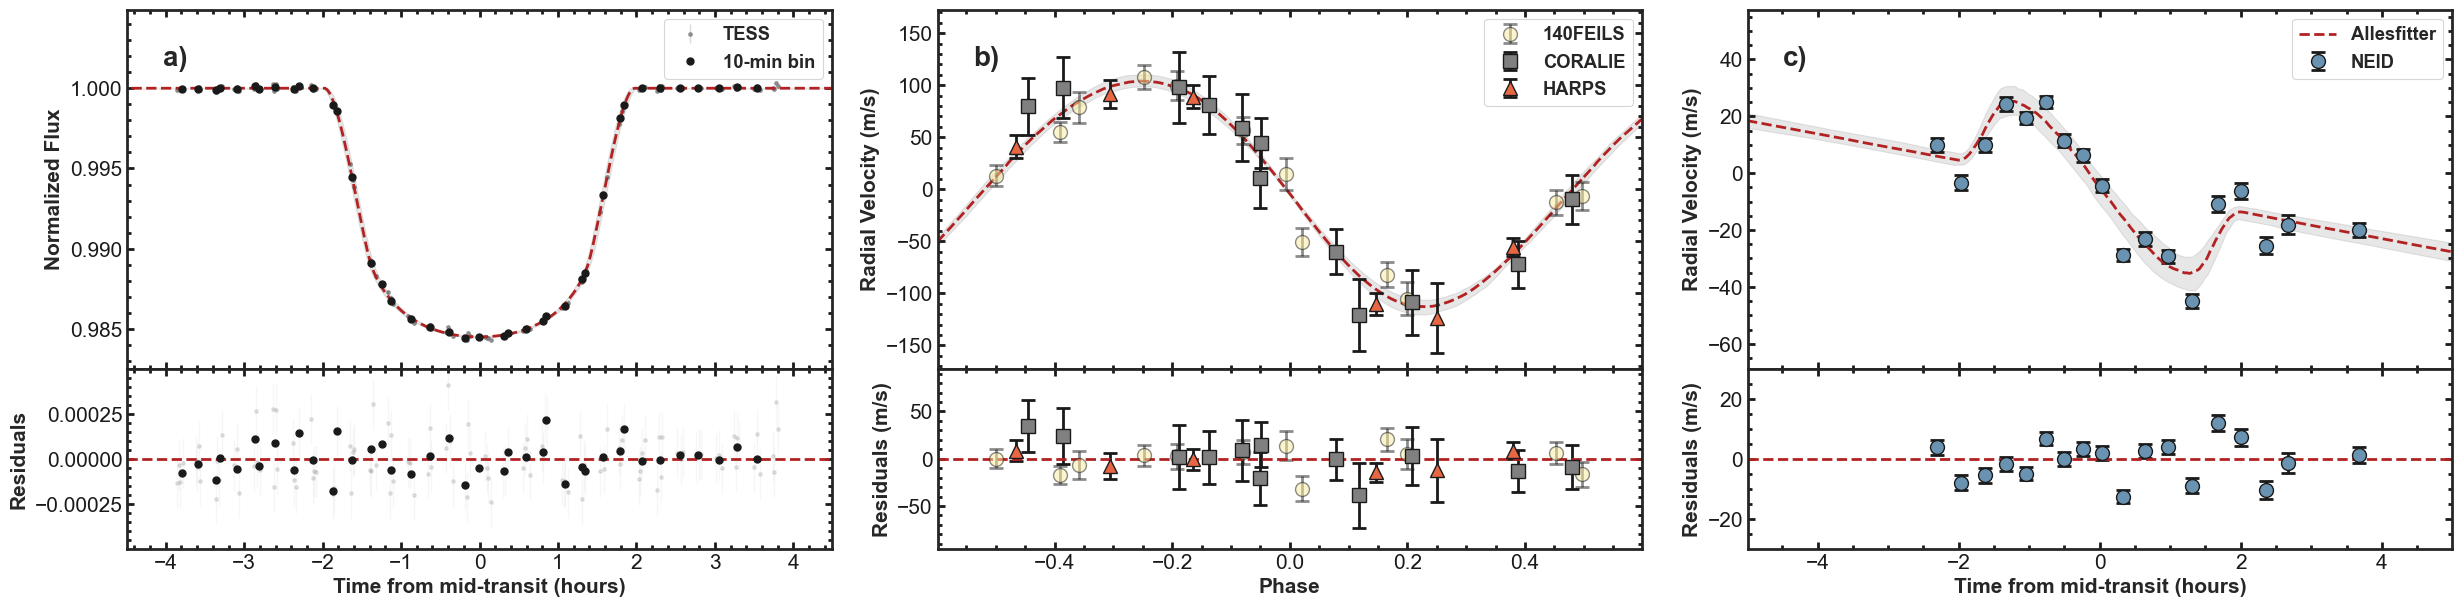

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# %matplotlib widget
import warnings
warnings.filterwarnings("ignore")


N = 100 # number of samples to plot
kms2ms = 1000 # convert km/s to m/s

burnin = int(posterior_samples.shape[0]*0.2)
my_seed = np.random.choice(np.arange(burnin, posterior_samples.shape[0]), N, replace=False)


fig = plt.figure(figsize=(30, 7))
grid_spec = gridspec.GridSpec(1, 3, figure=fig, wspace=0.15)

############################################################################################################
# Transit plot
############################################################################################################
subgrid_spec = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[0, 0], hspace=0, height_ratios=[2, 1])
ax1 = plt.subplot(subgrid_spec[0, 0])
ax2 = plt.subplot(subgrid_spec[1, 0])

ax = ax1
ax.text(0.05, 0.9, 'a)', fontsize=20, va='top', ha='left', transform=ax.transAxes, fontweight='bold')
x, y, yerr_w, model_x, model_50, model_16, model_84  = plot_my(ax, posterior_samples[my_seed,:], inst_phots[0],'b', 'phasezoom')
ax.errorbar(x, y, yerr=yerr_w, label='TESS', fmt='.', color='grey', ecolor='lightgrey', elinewidth=1, alpha=0.8, capsize=0, zorder=0)

# phase it
x, y, yerr_w = bin_lightcurve_fast(x, y, yerr_w, 10/60)
ax.errorbar(x[1:-1], y[1:-1], label='10-min bin', fmt='o',  capthick=2,color='k', capsize=5, mec='k', mfc='k', ms=5)
ax.plot(model_x, model_50, color='firebrick', lw=2, ls='--')
ax.fill_between(model_x, model_16, model_84, color='k', alpha=0.1)

# set the limits, labels, and ticks
ax.set_xlim(-4.49, 4.49)
ax.set_ylim(0.98251, 1.0049)
ax.set_ylabel('Normalized Flux', fontsize=15, fontweight='bold')
ax.legend(loc='upper right', fontsize=15, prop={'weight':'bold'})
ticksetax(ax)

# residuals
ax = ax2

# plot the residuals and 0 line
x, y, yerr_w = plot_my(ax, posterior_samples[my_seed,:], inst_phots[0],'b', 'phasezoom_residuals')
ax.errorbar(x, y, yerr=yerr_w, fmt='.', color='grey', ecolor='lightgrey', elinewidth=1, alpha=0.2, capsize=0, zorder=0)
x, y, yerr_w = bin_lightcurve_fast(x, y, yerr_w, 10/60)
ax.errorbar(x[1:-1], y[1:-1], label='TESS',fmt='o',  capthick=2,color='k', capsize=5, mec='k', mfc='k', ms=5)
ax.axhline(0, ls='--', color='firebrick', lw=2)

# set the limits, labels, and ticks
ax.set_xlim(-4.49, 4.49)
ax.set_ylim(-0.0004999, 0.0004999)
ax.set_ylabel('Residuals', fontsize=15, fontweight='bold')
ax.set_xlabel('Time from mid-transit (hours)', fontsize=15, fontweight='bold')
ticksetax(ax)


############################################################################################################
# RV plot
############################################################################################################
subgrid_spec = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[0, 1], hspace=0,  height_ratios=[2, 1])
ax1 = plt.subplot(subgrid_spec[0, 0])
ax2 = plt.subplot(subgrid_spec[1, 0], sharex=ax1)


# upper
ax = ax1
ax.text(0.05, 0.9, 'b)', fontsize=20, va='top', ha='left', transform=ax.transAxes, fontweight='bold')

x, y, yerr_w, xx, xx1, xx2, model_50, model_16, model_84  = plot_my(ax, posterior_samples[my_seed,:], inst_rvs[0],'b', 'phase')
y = y * kms2ms; yerr_w = yerr_w * kms2ms; model_50 = model_50 * kms2ms; model_16 = model_16 * kms2ms; model_84 = model_84 * kms2ms

# plot the phase-folded RV model
ax.plot(xx, model_50, color='firebrick', lw=2, ls='--')
ax.fill_between(xx, model_16, model_84, color='k', alpha=0.1)

ax.plot(xx+1, model_50, color='firebrick', lw=2, ls='--')
ax.fill_between(xx+1, model_16, model_84, color='k', alpha=0.1)

ax.plot(xx-1, model_50, color='firebrick', lw=2, ls='--')
ax.fill_between(xx-1, model_16, model_84, color='k', alpha=0.1)

# plot the phase-folded RV data
markers = ['o', 's', '^']
colors = ['#fbeb9b','gray','#e76745']
alphas = [0.5, 1, 1]
rvs = []
for i, rv_inst in enumerate(inst_rvs):
    x, y, yerr_w, xx, xx1, xx2, model_50, model_16, model_84  = plot_my(ax, posterior_samples[my_seed,:], rv_inst,'b', 'phase')
    x[x>0.5] = x[x>0.5] - 1
    y = y * kms2ms; yerr_w = yerr_w * kms2ms; model_50 = model_50 * kms2ms; model_16 = model_16 * kms2ms; model_84 = model_84 * kms2ms
    ax.errorbar(x, y, yerr=yerr_w, fmt='.', \
                label=rv_inst,\
        elinewidth=2, capthick=2,color='k', alpha=alphas[i], capsize=5, mec='k', mfc=colors[i], ms=10, marker=markers[i])
    rvs = rvs + list(y+yerr_w) + list(y-yerr_w)
rvs = np.array(rvs)

# set the limits, labels, and ticks
rv_max = np.max(np.abs(rvs))
ax.set_xlim(-0.599, 0.599)
ax.set_ylim(-rv_max*1.1, rv_max*1.1)
ax.legend(loc='upper right', fontsize=15, prop={'weight':'bold'})
ax.set_ylabel('Radial Velocity (m/s)', fontsize=15, fontweight='bold')
ticksetax(ax)

# residuals
ax = ax2

# plot the residuals and 0 line
for i, rv_inst in enumerate(inst_rvs):
    x, y, yerr_w = plot_my(ax, posterior_samples[my_seed,:], rv_inst,'b', 'phase_residuals')
    x[x>0.5] = x[x>0.5] - 1
    y = y * kms2ms; yerr_w = yerr_w * kms2ms
    ax.errorbar(x, y, yerr=yerr_w, fmt='.', \
                label=rv_inst,\
        elinewidth=2, capthick=2,color='k', alpha=alphas[i], capsize=5, mec='k', mfc=colors[i], ms=10, marker=markers[i])
ax.axhline(0, ls='--', color='firebrick', lw=2)

# set the limits, labels, and ticks
ax.set_ylim(-95, 95)
ax.set_xlim(-0.599, 0.599)
ax.set_ylabel('Residuals (m/s)', fontsize=15, fontweight='bold')
ax.set_xlabel('Phase', fontsize=15, fontweight='bold')
ticksetax(ax)

############################################################################################################
# RM plot
############################################################################################################
subgrid_spec = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=grid_spec[0, 2], hspace=0, height_ratios=[2, 1])
ax1 = plt.subplot(subgrid_spec[0, 0])
ax2 = plt.subplot(subgrid_spec[1, 0])

# upper
ax = ax1
ax.text(0.05, 0.9, 'c)', fontsize=20, va='top', ha='left', transform=ax.transAxes, fontweight='bold')

# derive the RM model and convert to m/s
x, y, yerr_w, xx, xx1, xx2, model_50, model_16, model_84  = plot_my(ax, posterior_samples[my_seed,:], 'KeckK2-140','b', 'phasezoom', data_type='rm')
y = y * kms2ms; yerr_w = yerr_w * kms2ms; model_50 = model_50 * kms2ms; model_16 = model_16 * kms2ms; model_84 = model_84 * kms2ms

# plot the RM data and model
ax.errorbar(x, y, yerr=yerr_w, fmt='o', elinewidth=2, capthick=2,color='k', capsize=5, mec='k', mfc='#6993b1', ms=10, label='NEID')
ax.plot(xx1*24, model_50, color='firebrick', lw=2, ls='--', label='Allesfitter')
ax.fill_between(xx1*24, model_16, model_84, color='k', alpha=0.1)

# set the limits, labels, and ticks
ax.set_xlim(-4.99, 4.999)
ax.legend(loc='upper right', fontsize=15, prop={'weight':'bold'})
ax.set_ylabel('Radial Velocity (m/s)', fontsize=15, fontweight='bold')
ticksetax(ax)

# Residuals plot
ax = ax2

# derive the RM residuals and convert to m/s
_, y, yerr_w = plot_my(ax, posterior_samples[my_seed,:], 'KeckK2-140','b','phasezoom_residuals')
y = y * kms2ms; yerr_w = yerr_w * kms2ms

# plot the residuals and 0 line
ax.errorbar(x, y, yerr=yerr_w, fmt='o', elinewidth=2, capthick=2,color='k', capsize=5, mec='k', mfc='#6993b1', ms=10)
ax.axhline(0, ls='--', color='firebrick', lw=2)

# set the limits, labels, and ticks
ax.set_xlim(-4.99, 4.999)
ax.set_ylim(-29.999, 29.999)
ax.set_ylabel('Residuals (m/s)', fontsize=15, fontweight='bold')
ax.set_xlabel('Time from mid-transit (hours)', fontsize=15, fontweight='bold')
ticksetax(ax)


